In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
"""matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})"""


import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [6]:
data_dir = Path("../../../data")
cache_dir = Path("../../../experiment_cache/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=78637921):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

100%|████████████████████████| 170498071/170498071 [00:21<00:00, 7930597.33it/s]


Extracting ../../../data/cifar-10-python.tar.gz to ../../../data
Files already downloaded and verified


In [7]:
imgs = torch.stack([img_t for img_t, _ in train_set], dim=3)

mean = imgs.view(3,-1).mean(dim=1).numpy()

std = imgs.view(3,-1).std(dim=1).numpy()

transforms.Normalize((mean[0], mean[1], mean[2]), (std[0], std[1],std[2]))

Normalize(mean=(0.49139965, 0.48215845, 0.44653094), std=(0.24703224, 0.24348514, 0.26158786))

In [8]:
train_set_n = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((mean[0], mean[1], mean[2]), (std[0], std[1],std[2]))]))
test_set_n = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((mean[0], mean[1], mean[2]), (std[0], std[1],std[2]))]))

train_data_n = {
    "x": torch.tensor(((train_set_n.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(train_set_n.targets),
}

test_data_n = {
    "x": torch.tensor(((test_set_n.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(test_set_n.targets),
}

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f"Training Data Length: ", len(train_data_n["x"]))
print(f"Testing Data Length: ", len(test_data_n["x"]))

Training Data Length:  50000
Testing Data Length:  10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


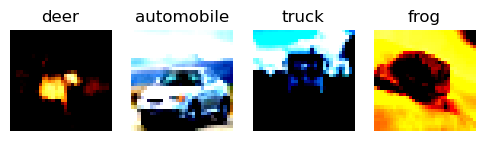

In [10]:
img, lab = train_set_n[3]
img2, lab2 = train_set_n[49998]
img3, lab3 = train_set_n[49997]
img4, lab4 = train_set_n[49996]
fig, axs = plt.subplots(1,4, figsize=(6,1.5))
axs[0].imshow(img.permute(1,2,0))
axs[0].set_title(train_set.classes[lab])
axs[0].set_axis_off()
axs[1].imshow(img2.permute(1,2,0))
axs[1].set_title(train_set.classes[lab2])
axs[1].set_axis_off()
axs[2].imshow(img3.permute(1,2,0))
axs[2].set_title(train_set.classes[lab3])
axs[2].set_axis_off()
axs[3].imshow(img4.permute(1,2,0))
axs[3].set_title(train_set.classes[lab4])
axs[3].set_axis_off()
#plt.savefig('Cifar10_example_data.pgf', pad_inches=0)
plt.show()

In [22]:
# Get client splits.
client_data = homogeneous_split(train_data_n, 10, seed=42)


In [24]:
client_data[0]["x"][0].dtype

torch.float32

## Define configuration for server and clients

In [25]:
model_config = {
    "input_dim": 3072,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(20, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 1500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha": 1.5
}

server_config = {
    **client_config,
    #100
    "max_iterations": 100,
}

## Set up model etc.

In [26]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data_n
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data_n, val_data=test_data_n)

## Run PVI! 1 Hidden Layer

In [27]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 7759.017.
Test mll: -1.792. Test acc: 0.360.
Train mll: -1.792. Train acc: 0.359.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 8250.917.
Test mll: -1.777. Test acc: 0.363.
Train mll: -1.775. Train acc: 0.362.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 8817.699.
Test mll: -1.771. Test acc: 0.367.
Train mll: -1.767. Train acc: 0.369.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 9190.818.
Test mll: -1.765. Test acc: 0.370.
Train mll: -1.762. Train acc: 0.371.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 12210.695.
Test mll: -1.762. Test acc: 0.373.
Train mll: -1.759. Train acc: 0.374.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 14467.264.
Test mll: -1.759. Test acc: 0.374.
Train mll: -1.756. Train acc: 0.377.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 14769.875.
Test mll: -1.756. Test acc: 0.373.
Train mll: -1.754. Train acc: 0.376.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 15125.591.
Test mll: -1.754. Test acc: 0.376.
Train mll: -1.752. Train acc: 0.377.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 16445.606.
Test mll: -1.754. Test acc: 0.377.
Train mll: -1.750. Train acc: 0.379.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 17257.520.
Test mll: -1.752. Test acc: 0.378.
Train mll: -1.749. Train acc: 0.380.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 17614.556.
Test mll: -1.751. Test acc: 0.379.
Train mll: -1.748. Train acc: 0.379.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 17919.887.
Test mll: -1.752. Test acc: 0.377.
Train mll: -1.748. Train acc: 0.379.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 18304.900.
Test mll: -1.749. Test acc: 0.380.
Train mll: -1.747. Train acc: 0.380.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 18713.591.
Test mll: -1.749. Test acc: 0.377.
Train mll: -1.745. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 19116.972.
Test mll: -1.748. Test acc: 0.380.
Train mll: -1.745. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 19506.541.
Test mll: -1.748. Test acc: 0.380.
Train mll: -1.745. Train acc: 0.380.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 19935.640.
Test mll: -1.746. Test acc: 0.382.
Train mll: -1.743. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 20375.031.
Test mll: -1.746. Test acc: 0.381.
Train mll: -1.743. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 20792.993.
Test mll: -1.747. Test acc: 0.380.
Train mll: -1.743. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 21168.779.
Test mll: -1.746. Test acc: 0.380.
Train mll: -1.743. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 21557.141.
Test mll: -1.746. Test acc: 0.380.
Train mll: -1.743. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 22004.362.
Test mll: -1.746. Test acc: 0.380.
Train mll: -1.742. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 23466.907.
Test mll: -1.745. Test acc: 0.381.
Train mll: -1.742. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 24148.461.
Test mll: -1.745. Test acc: 0.382.
Train mll: -1.741. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 24523.309.
Test mll: -1.746. Test acc: 0.381.
Train mll: -1.741. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 24953.250.
Test mll: -1.745. Test acc: 0.381.
Train mll: -1.741. Train acc: 0.381.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 25278.921.
Test mll: -1.745. Test acc: 0.382.
Train mll: -1.741. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 25726.462.
Test mll: -1.745. Test acc: 0.382.
Train mll: -1.741. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 26132.913.
Test mll: -1.744. Test acc: 0.383.
Train mll: -1.741. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 26552.785.
Test mll: -1.744. Test acc: 0.384.
Train mll: -1.740. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 26905.682.
Test mll: -1.744. Test acc: 0.387.
Train mll: -1.740. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 27371.324.
Test mll: -1.744. Test acc: 0.382.
Train mll: -1.740. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 27814.226.
Test mll: -1.744. Test acc: 0.382.
Train mll: -1.740. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 28250.903.
Test mll: -1.744. Test acc: 0.382.
Train mll: -1.740. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 28632.345.
Test mll: -1.744. Test acc: 0.385.
Train mll: -1.740. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 29042.741.
Test mll: -1.744. Test acc: 0.383.
Train mll: -1.740. Train acc: 0.382.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 29440.355.
Test mll: -1.744. Test acc: 0.383.
Train mll: -1.740. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 29823.669.
Test mll: -1.743. Test acc: 0.383.
Train mll: -1.739. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 30186.218.
Test mll: -1.744. Test acc: 0.385.
Train mll: -1.739. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 30595.752.
Test mll: -1.743. Test acc: 0.384.
Train mll: -1.739. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 30964.847.
Test mll: -1.743. Test acc: 0.383.
Train mll: -1.739. Train acc: 0.383.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 31403.186.
Test mll: -1.743. Test acc: 0.385.
Train mll: -1.739. Train acc: 0.384.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 31794.408.
Test mll: -1.743. Test acc: 0.382.
Train mll: -1.739. Train acc: 0.384.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

In [25]:
model_config2 = {
    "input_dim": 3072,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config2 = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-4},
    "sigma_optimiser_params": {"lr": 2e-4},
    "early_stopping": EarlyStopping(20, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 1500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha": 0.75
}

server_config2 = {
    **client_config2,
    #100
    "max_iterations": 27,
}

In [26]:
device2 = server_config2["device"]

model2 = ClassificationBNNLocalRepam(config=model_config2)

# Initial parameters.
init_q_std_params2 = {
    "loc": torch.zeros(size=(model2.num_parameters,)).to(device2).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model2.num_parameters,)).to(device2) 
    * client_config2["init_var"] ** 0.5,
}

prior_std_params2 = {
    "loc": torch.zeros(size=(model2.num_parameters,)).to(device2),
    "scale": model_config2["prior_var"] ** 0.5 
    * torch.ones(size=(model2.num_parameters,)).to(device2),
}

init_factor_nat_params2 = {
    "np1": torch.zeros(model2.num_parameters).to(device2),
    "np2": torch.zeros(model2.num_parameters).to(device2),
}

p2 = MeanFieldGaussianDistribution(
    std_params=prior_std_params2, is_trainable=False
)
init_q2 = MeanFieldGaussianDistribution(
    std_params=init_q_std_params2, is_trainable=False
)

clients2 = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients2.append(
        Client(
            data=data_i,
            model=model2,
            t=t_i,
            config=client_config2,
            val_data=test_data
        )
    )    
server2 = SequentialServer(model=model2, p=p2, clients=clients2, config=server_config2, init_q=init_q2, data=train_data, val_data=test_data)

In [27]:
i = 0
while not server2.should_stop():
    server2.tick()

    # Obtain performance metrics.
    metrics = server2.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 6162.285.
Test mll: -1.756. Test acc: 0.377.
Train mll: -1.753. Train acc: 0.379.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 7286.505.
Test mll: -1.740. Test acc: 0.385.
Train mll: -1.735. Train acc: 0.387.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 8992.684.
Test mll: -1.726. Test acc: 0.387.
Train mll: -1.722. Train acc: 0.391.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 9529.163.
Test mll: -1.720. Test acc: 0.392.
Train mll: -1.715. Train acc: 0.393.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 10063.707.
Test mll: -1.715. Test acc: 0.394.
Train mll: -1.710. Train acc: 0.395.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 10731.659.
Test mll: -1.709. Test acc: 0.397.
Train mll: -1.704. Train acc: 0.397.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 11386.242.
Test mll: -1.705. Test acc: 0.395.
Train mll: -1.700. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 12160.955.
Test mll: -1.702. Test acc: 0.397.
Train mll: -1.697. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 12852.626.
Test mll: -1.697. Test acc: 0.399.
Train mll: -1.693. Train acc: 0.399.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 13460.171.
Test mll: -1.695. Test acc: 0.401.
Train mll: -1.691. Train acc: 0.401.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 14085.041.
Test mll: -1.693. Test acc: 0.403.
Train mll: -1.688. Train acc: 0.403.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 14638.440.
Test mll: -1.689. Test acc: 0.407.
Train mll: -1.684. Train acc: 0.404.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 15145.643.
Test mll: -1.689. Test acc: 0.403.
Train mll: -1.683. Train acc: 0.402.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 15642.878.
Test mll: -1.686. Test acc: 0.409.
Train mll: -1.682. Train acc: 0.404.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 16228.894.
Test mll: -1.685. Test acc: 0.405.
Train mll: -1.680. Train acc: 0.406.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 16749.120.
Test mll: -1.685. Test acc: 0.406.
Train mll: -1.680. Train acc: 0.406.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 17275.436.
Test mll: -1.683. Test acc: 0.406.
Train mll: -1.680. Train acc: 0.405.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 17820.728.
Test mll: -1.681. Test acc: 0.408.
Train mll: -1.678. Train acc: 0.407.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 18367.207.
Test mll: -1.684. Test acc: 0.406.
Train mll: -1.680. Train acc: 0.403.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 19116.437.
Test mll: -1.680. Test acc: 0.408.
Train mll: -1.676. Train acc: 0.405.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 19655.196.
Test mll: -1.680. Test acc: 0.412.
Train mll: -1.675. Train acc: 0.407.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 20163.097.
Test mll: -1.676. Test acc: 0.410.
Train mll: -1.673. Train acc: 0.408.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 21456.007.
Test mll: -1.676. Test acc: 0.409.
Train mll: -1.673. Train acc: 0.406.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 22016.417.
Test mll: -1.677. Test acc: 0.407.
Train mll: -1.675. Train acc: 0.406.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 22658.359.
Test mll: -1.678. Test acc: 0.410.
Train mll: -1.675. Train acc: 0.408.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 23174.934.
Test mll: -1.678. Test acc: 0.404.
Train mll: -1.674. Train acc: 0.404.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 23751.922.
Test mll: -1.674. Test acc: 0.410.
Train mll: -1.671. Train acc: 0.409.



In [44]:
model_config3 = {
    "input_dim": 3072,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config3 = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 2e-4},
    "sigma_optimiser_params": {"lr": 2e-4},
    "early_stopping": EarlyStopping(20, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 256,
    "epochs": 1500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "KLD",
    "alpha": 1.0
}

server_config3 = {
    **client_config3,
    #100
    "max_iterations": 5,
}

In [43]:
client_data_1= homogeneous_split(train_data,1)

In [45]:
device3 = server_config3["device"]

model3 = ClassificationBNNLocalRepam(config=model_config3)

# Initial parameters.
init_q_std_params3 = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model3.num_parameters,)).to(device3) 
    * client_config3["init_var"] ** 0.5,
}

prior_std_params3 = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3),
    "scale": model_config3["prior_var"] ** 0.5 
    * torch.ones(size=(model3.num_parameters,)).to(device3),
}

init_factor_nat_params3 = {
    "np1": torch.zeros(model3.num_parameters).to(device3),
    "np2": torch.zeros(model3.num_parameters).to(device3),
}

p3 = MeanFieldGaussianDistribution(
    std_params=prior_std_params3, is_trainable=False
)
init_q3 = MeanFieldGaussianDistribution(
    std_params=init_q_std_params3, is_trainable=False
)

clients3 = []
size_training = 0
for i in range(1):
    data_i = client_data_1[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients3.append(
        Client(
            data=data_i,
            model=model3,
            t=t_i,
            config=client_config3,
            val_data=test_data
        )
    )    
server3 = SequentialServer(model=model3, p=p3, clients=clients3, config=server_config3, init_q=init_q3, data=train_data, val_data=test_data)


In [46]:
i = 0
while not server3.should_stop():
    server3.tick()

    # Obtain performance metrics.
    metrics = server3.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 13782.480.
Test mll: -1.606. Test acc: 0.446.
Train mll: -1.599. Train acc: 0.446.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 14292.785.
Test mll: -1.604. Test acc: 0.445.
Train mll: -1.597. Train acc: 0.445.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 14889.651.
Test mll: -1.604. Test acc: 0.450.
Train mll: -1.597. Train acc: 0.447.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 15119.180.
Test mll: -1.602. Test acc: 0.443.
Train mll: -1.597. Train acc: 0.445.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 15516.450.
Test mll: -1.601. Test acc: 0.450.
Train mll: -1.595. Train acc: 0.447.



In [47]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
    
train_acc2 = []
val_acc2 = []
times2 = []
train_acc2.append(100.0)
val_acc2.append(100.0)
times2.append(1.0)
for metrics in server2.log["performance_metrics"]:
    train_acc2.append(100-metrics["train_acc"]*100)
    val_acc2.append(100-metrics["val_acc"]*100)
    times2.append(metrics["time"])
    
train_acc3 = []
val_acc3 = []
times3 = []
train_acc3.append(100.0)
val_acc3.append(100.0)
times3.append(1.0)
for metrics in server3.log["performance_metrics"]:
    train_acc3.append(100-metrics["train_acc"]*100)
    val_acc3.append(100-metrics["val_acc"]*100)
    times3.append(metrics["time"])
    
    
plt.figure(figsize=(6,4))
plt.xscale("log")
plt.yscale("log")
plt.ylim(50,100)
plt.plot(times, val_acc, label=r"PGVI with $D_{AR}^{(1.5)}$", linewidth=1)
plt.plot(times2, val_acc2, label=r"PVI with KL", linewidth=1)
plt.plot(times3, val_acc3, label=r"VI comparison", linewidth=1)
plt.xlabel("Time")
plt.ylabel("% Testing Error")
plt.legend(loc="upper right", frameon=False)
plt.grid(visible=True)
#plt.savefig('PGVI_CIFAR10_ARD_KL_VI.pgf', pad_inches=0)
plt.show()

/var/folders/6x/7wzwn4g54n38_8rfbfx611n00000gn/T/ipykernel_21597/3307487189.py:47: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
